# Code Starter for all my methodologies

This code runs for a given file and stores the following stuff:

1. ref_ts : this is a list. it is the whole reference timeseries of interest. This code is written based on 2025-2035. The years can be changed.
2. sub_ts : this is a dictionary. The keys are in sub_ts_xxxx, where xxxx refers to the subset year from the reference timeseries. The values are for the variables of the file.
3. monthly_data : this is a dictionary. it contains the data for each month, in a separate key:value pair. for instance, Janx key has the values of all {VARIABLE} for all januaries in the timeseries. This dictionary is useful for intra-month calculation of statistics and metrics.
4. monthly_stats : this is a dictionary which contains the mean, median, standard deviation and 'most probable' value for that month.
5. synthetic_year_mean, synthetic_year_median, synthetic_year_most_probable : these are lists that contain values from monthly_stats to form synthetic years


## Modules and Functions

In [67]:
#installing required modules from python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from scipy.spatial.distance import jensenshannon
import matplotlib.dates as mdates
import os
import sys

In [68]:
# Functions for pre-processing of data

def variable_histogram():
    plt.figure(figsize=(12, 6))
    plt.hist(data[variable], bins=50, density=True,color='aquamarine', edgecolor='black')
    density = gaussian_kde(data[variable])
    xs = np.linspace(data[variable].min(), data[variable].max(), 200)
    plt.plot(xs, density(xs), 'b-', linewidth=2)
    plt.title(f'Histogram and Density Plot of {variable}')
    plt.xlabel(f'{variable} Values')
    plt.ylabel('Density')
    plt.show()


def ref_ts_plot(startyear, endyear, variable):
    global ref_ts
    filtered_data = ref_ts[(ref_ts['Date'].dt.year >= startyear) & (ref_ts['Date'].dt.year <= endyear)]
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['Date'], filtered_data[variable], linestyle='-', color='k')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=90)
    plt.title(f'Time Series from {startyear} to {endyear}')
    plt.xlabel('Date')
    plt.ylabel(f'{variable}')
    plt.show()


def create_subsets():
    if mode == 'CY':
        # Loop through the range of years and create subsets, storing them in the dictionary
        for year in range(startyear, endyear + 1):
            # Creating a dictionary key for each year
            key = f"sub_ts_{year}"
            # Filtering data for the current year
            sub_ts[key] = data[data['Date'].dt.year == year]

    elif mode == '12M':
        filtered_data_length = len(data)
        
        # Loop through the range of months and create subsets, storing them in the dictionary
        for i in range(filtered_data_length - 11):
            # Get 12 consecutive months of data
            subts = data.iloc[i:i + 12]
            
            # Define the key for the dictionary using the month range
            start_date = subts.iloc[0]['Date']
            end_date = subts.iloc[-1]['Date']
            key = f"sub_ts_{start_date.strftime('%b%Y')}_{end_date.strftime('%b%Y')}"
            
            # Ensure the subset is within the specified date range
            if start_date.year >= startyear and end_date.year <= endyear:
                # Store the 12-consecutive-month subset in the dictionary
                sub_ts[key] = subts

## Functions for method 1:

# Function to calculate PDFs
def calculate_pdfs(data_slice):
    mean, std = data_slice[variable].mean(), data_slice[variable].std()
    pdf = norm.pdf(variable_full_range, mean, std)
    return pdf

def all_m1plots():
    # Plot all PDFs together in one graph 
    plt.figure(figsize=(14, 8))
    for var_name, subts_pdf in subts_pdfs.items():
        plt.plot(variable_full_range, subts_pdf, label=var_name, linestyle='--', linewidth=1)
    plt.plot(variable_full_range, ref_pdf, label='RefTS (Normal Distribution Fit)', color='red', linestyle='-', linewidth=3)
    plt.title(f'Normal Distribution Fits for {variable} Across Different Years')
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

def top_n_m1plots():

    # Sort JS divergence values and print them in ascending order
    # Define a function to get the value from a dictionary item
    def get_js_value(item):
        return item[1]
    
    # Sort JS divergence values and print them in ascending order
    global sorted_js_divergence
    sorted_js_divergence = dict(sorted(js_divergence.items(), key=get_js_value))
    
    # Plot top 10 PDFs with the reference PDF in one graph
    # Extract the top 10 JS divergence entries
    global top_n_js_divergence
    top_n_js_divergence = list(sorted_js_divergence.items())[:n]
    
    # Plot reference PDF and top 10 PDFs
    plt.figure(figsize=(14, 8))
    for var_name, js_value in top_n_js_divergence:
        plt.plot(variable_full_range, subts_pdfs[var_name], label=f'{var_name} (JS Div: {js_value:.4f})', linestyle='--', linewidth=1)
    plt.plot(variable_full_range, ref_pdf, label='RefTS (Normal Distribution Fit)', color='red', linestyle='-', linewidth=3)
    plt.title(f'Top {n} Normal Distribution Fits for {variable} Compared to RefTS')
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def top_n_m1subplots():
    num_plots = min(n, len(top_n_js_divergence))
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))
    axes = axes.flatten()
    for idx, (var_name, js_value) in enumerate(top_n_js_divergence[:num_plots]):
        ax = axes[idx]
        ax.plot(variable_full_range, ref_pdf, label='RefTS', color='red', linestyle='-', linewidth=3)
        ax.plot(variable_full_range, subts_pdfs[var_name], label=f'{var_name} (JS Div: {js_value:.4f})', linestyle='--', linewidth=2)
        ax.set_title(f'{var_name}')
        ax.set_xlabel(variable)
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True)
    for i in range(idx + 1, num_rows * num_cols):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

# Functions for method 2:
def create_synthetic_years():

## Initializations
    global monthly_data, months_order, synthetic_year_mean, synthetic_year_median, synthetic_year_most_probable
    monthly_data = {
        'Jan': [], 'Feb': [], 'Mar': [], 'Apr': [], 'May': [],
        'Jun': [], 'Jul': [], 'Aug': [], 'Sep': [], 'Oct': [],
        'Nov': [], 'Dec': []
    }
    monthly_stats = {}
    
    months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']   
    synthetic_year_mean = []
    synthetic_year_median = []
    synthetic_year_most_probable = []
    
    
    ## Extractions and Calculations
    # Extract and store data for each month across all years
    for year in range(startyear, endyear + 1):
        for month in range(1, 13):  # From January (1) to December (12)
            month_subset = data[(data['Date'].dt.year == year) & (data['Date'].dt.month == month)]
            month_name = month_subset['Date'].dt.strftime('%b').iloc[0]
            if not month_subset.empty:
                monthly_data[month_name].extend(month_subset[variable].tolist())
    
    # Calculate statistics
    for month, values in monthly_data.items():
        if values:  # Ensure there are values to calculate statistics
            mean_val = np.mean(values)
            median_val = np.median(values)
            std_dev_val = np.std(values)
            
            # Calculate the most probable value using histogram binning
            hist, bin_edges = np.histogram(values, bins='auto')
            max_bin_index = np.argmax(hist)
            most_probable_val = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
            
            # Store the statistics in the dictionary
            monthly_stats[month] = {
                'mean': mean_val,
                'median': median_val,
                'most_probable': most_probable_val,
                'std_dev': std_dev_val
            }
            
            # # Print the statistics
            # print(f"{month} - Mean: {mean_val}, Median: {median_val}, Most Probable: {most_probable_val}, Std Dev: {std_dev_val}")
           
    
    for month in months_order:
        if month in monthly_stats:
            synthetic_year_mean.append(monthly_stats[month]['mean'])
            synthetic_year_median.append(monthly_stats[month]['median'])
            synthetic_year_most_probable.append(monthly_stats[month]['most_probable'])
        else:
            synthetic_year_mean.append(np.nan)
            synthetic_year_median.append(np.nan)
            synthetic_year_most_probable.append(np.nan)


def rmse(observed, simulated):
    return np.sqrt(np.mean((simulated - observed) ** 2))

def euclidean_distance(observed, simulated):
    return np.linalg.norm(simulated - observed)

def run_method2():
    if mode == 'CY':
        # Processing Output for SY Methods
        months_order = list(monthly_data.keys())
        metrics = ['RMSE']
        results = []
        for key in sub_ts:
            sub_ts_monthly = sub_ts[key].groupby(sub_ts[key]['Date'].dt.month)[variable].mean().values
            results.append({
                'Year': key,
                'RMSE': rmse(sy, sub_ts_monthly),    #CHANGCE HERE FOR OTHER SYNTHETIC YEARS
            })
        
        results_df = pd.DataFrame(results)
        results_df.sort_values(by='RMSE', inplace=True)
        results_df.reset_index(drop=True, inplace=True)
        
        #Plotting years for synthetic_year_methods
        plt.figure(figsize=(14, 7))
        for key in sub_ts:
            sub_ts_monthly = sub_ts[key][variable].values
            plt.plot(months_order, sub_ts_monthly, linestyle='--', linewidth=1, label=key)
        plt.plot(months_order, sy, marker='o', linestyle='-', linewidth=3, label=sy_label)
        plt.title(f'Comparison of CY sub_ts with {sy_label}')
        plt.xlabel('Month')
        plt.ylabel(f'{variable} Values')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        num_years = min(n, len(sub_ts))
        num_cols = 2
        num_rows = (num_years + num_cols - 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))
        axes = axes.flatten()
        for idx, row in results_df.head(n).iterrows():
            ax = axes[idx]
            key = row['Year']
            sub_ts_monthly = sub_ts[key][variable].values
            ax.plot(months_order, sy, marker='o', linestyle='-', linewidth=1, label=sy_label) #CHANGCE HERE FOR OTHER SYNTHETIC YEARS
            ax.plot(months_order, sub_ts_monthly, linestyle='--', linewidth=1, label=key)
            ax.set_title(f"{key} (RMSE: {row['RMSE']:.8f})")
            ax.set_xlabel('Month')
            ax.set_ylabel(f'{variable} Values')
            ax.legend()
            ax.grid(True)
        
        # Remove any empty subplots
        for i in range(idx + 1, num_rows * num_cols):
            fig.delaxes(axes[i])
        plt.tight_layout()
        plt.show()
    
        return results_df

    elif mode == '12M':
        # Indexed so I can get rid of the lag when I plot it.
        indexed_sub_ts = {}
        for key, subts in sub_ts.items():
            start_date = subts.iloc[0]['Date']
            start_month_index = start_date.month - 1  # Convert to 0-based index
            month_indices = [(start_month_index + j) % 12 for j in range(12)]
            indexed_subts = subts.copy()
            indexed_subts['Month_Index'] = month_indices
            indexed_sub_ts[key] = indexed_subts
        sorted_indexed_sub_ts = {}
        for key, df in indexed_sub_ts.items():
            sorted_indexed_sub_ts[key] = df.sort_values(by='Month_Index', ascending=True)
        sub_ts_sbmi = {key: df.drop(columns=['Month_Index']) for key, df in sorted_indexed_sub_ts.items()}
        
        # Create a dictionary to store synthetic year and sub_ts_sbmi data
        data_dict = {}
        if sy == synthetic_year_mean:
            data_dict['synthetic_year_mean'] = sy
        elif sy == synthetic_year_median:
            data_dict['synthetic_year_median'] = sy
        elif sy == synthetic_year_most_probable:
            data_dict['synthetic_year_most_probable'] = sy
        
        
        # Add sub_ts_sbmi data to the dictionary
        for key in sub_ts_sbmi:
            sub_ts_monthly = sub_ts_sbmi[key][variable].values
            start_month = sub_ts_sbmi[key]['Date'].dt.month.iloc[0] - 1  # Adjusting to 0-based index
            data_dict[key] = (start_month, sub_ts_monthly)
        
        paired_data = {}
        for key in sub_ts_sbmi:
            sub_ts_monthly = sub_ts_sbmi[key][variable].values
            
            paired_data[key] = {
                'sub_ts_monthly': sub_ts_monthly,
                'synthetic_year': sy  # mean, median, maximum probable
            }
        
        
        metrics = ['RMSE']
        results = []
        for key in paired_data:
            sub_ts_monthly = paired_data[key]['sub_ts_monthly']
            synthetic_year = paired_data[key]['synthetic_year']
            results.append({
                'Year': key,
                'RMSE': rmse(synthetic_year, sub_ts_monthly)    # Compute RMSE
            })
        
        results_df = pd.DataFrame(results)
        results_df.sort_values(by='RMSE', inplace=True)
        results_df.reset_index(drop=True, inplace=True)
        
        # Plot all sub_ts_sbmi time series in one graph along with the synthetic years (mean)
        plt.figure(figsize=(14, 7))
        for key in data_dict:
            if key == 'synthetic_year_mean' or key == 'synthetic_year_median' or key == 'synthetic_year_most_probable':
                plt.plot(range(12), data_dict[key], marker='o', linestyle='-', linewidth=3, color='red', label=sy_label)
            else:
                start_month, values = data_dict[key]
                months = [(start_month + i) % 12 for i in range(len(values))]
                plt.plot(months, values, linestyle='--', linewidth=0.5, label=key)
        
        
        plt.title(f'Comparison of 12M sub_ts with {sy_label}')
        plt.xlabel('Month')
        plt.ylabel(f'{variable} Values')
        plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.grid(True)
        plt.show()
        
        num_years = min(n, len(sub_ts))
        num_cols = 2
        num_rows = (num_years + num_cols - 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))
        axes = axes.flatten()
        for idx, row in results_df.head(n).iterrows():
            ax = axes[idx]
            key = row['Year']
            sub_ts_monthly = paired_data[key]['sub_ts_monthly']
            synthetic_year = paired_data[key]['synthetic_year']
            ax.plot(range(12), sub_ts_monthly, linestyle='--', linewidth=1, label=key)           
            ax.plot(range(12), synthetic_year, marker='o', linestyle='-', linewidth=2, label=sy_label) # mean, median, maximum probable
            ax.set_title(f"{key} (RMSE: {row['RMSE']:.8f})")
            ax.set_xlabel('Month')
            ax.set_ylabel(f'{variable} Values')
            ax.legend()
            ax.grid(True)
        
        # Remove any empty subplots
        for i in range(idx + 1, num_rows * num_cols):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()

        return results_df


## Inputs

The following codeblock is for filename and directory of your csv file. Yep, it needs a specific format to be input in here.
1. I wrote this script for csv files of a specific format: 2 columns: Date, VARIABLE, where VARIABLE refers to the variable  you are workin on e.g THETAO, PR, TOS, UO, VO, CHL, O2, PH etc. The csv file must be a complete timeseries with no missing values. I have hardcoded the data processing part for monthly data e.g Amon, Omon.
2. Ensure your Date column is in the format='%d-%b-%Y' i.e date-Mon-year. Yep, months to be in 3 alphabets with 1st alphabet capital.
3. Your csv file should be named in the format {location}_{variable}_{scenario}.csv e.g BORSSELE_THETAO_585.csv
4. You must specify the startyear and endyear for selecting representative year i.e if you are looking for mid term, 11 year span for 2050s, your startyear, endyear = 2045, 2055.

In [69]:
file_path = f'H:/M.Sc Thesis - Data, Methodology, Results/SVM Script and Data/FMBORS_SO_585.csv'

startyear, endyear = 2030, 2040

## Data Processing

In [70]:
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%Y')


ref_ts = data[(data['Date'].dt.year >= startyear) & (data['Date'].dt.year <= endyear)] #Reference timeslice, full range of years inclusive.

# Please ensure the input file's date column is in the format %d-%b-%Y.
#If it is not, please open the file and save the Date column in a 14-Mar-2015 kind of format, save the csv file again, and then read the file.

Codeblock for extracting filename and parts from the filename, will be used later

In [71]:
# Extract the filename and parts from the filename
filename = file_path.split('/')[-1]
parts = filename.split('_')
location = parts[0].upper()
variable = parts[1].upper()
scenario = parts[2].split('.')[0]

# print(f"{location}\n{variable}\n{scenario}")

The following codeblock is for plotting refts and its histogram only

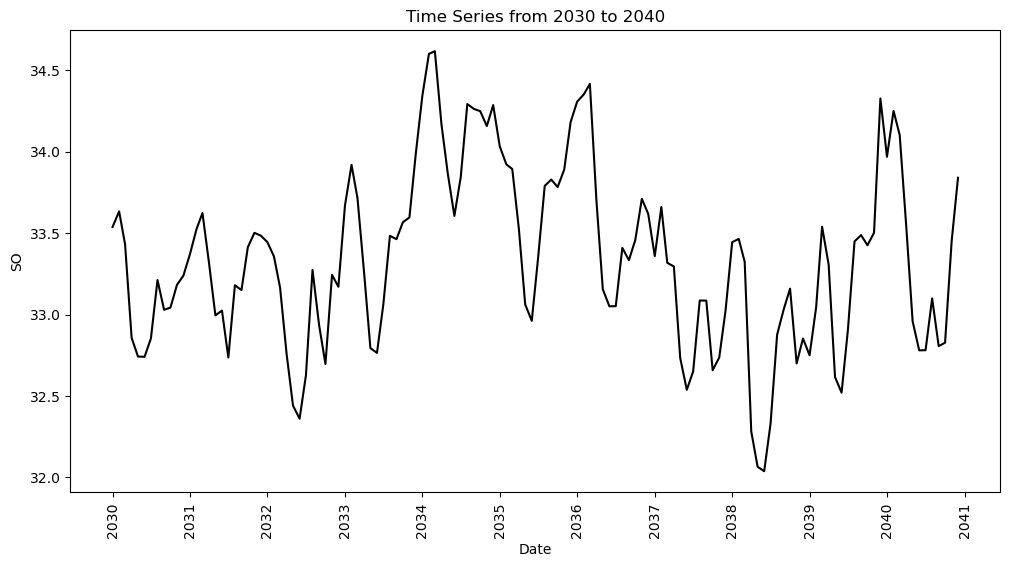

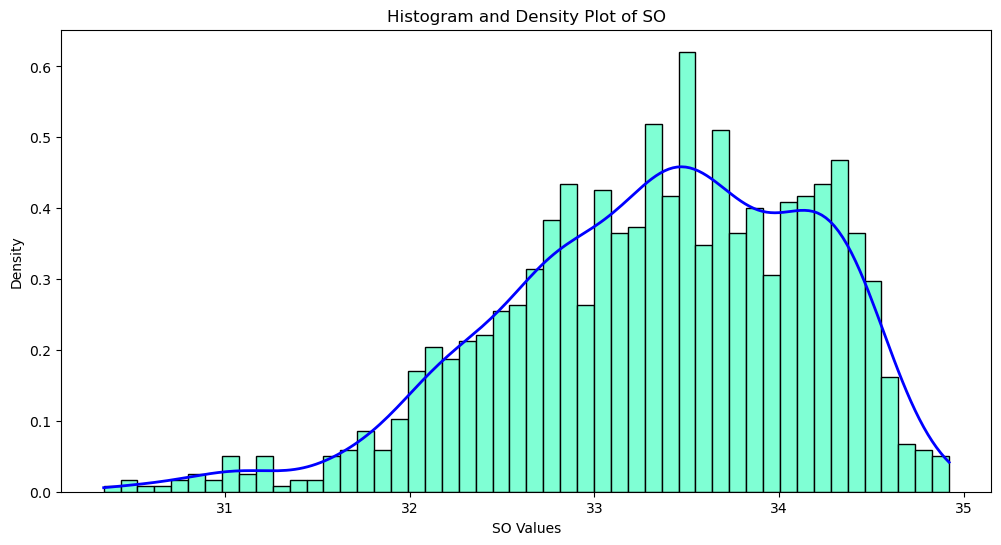

In [72]:
ref_ts_plot(startyear, endyear, variable)  #If you want to see specific year, then put startyear=2025, endyear=2025, variable=variable; 
#or if you want to see a specific slice, then put startyear=2021, endyear=2023, variable=variable
variable_histogram()

The following codeblock is for generating sub_ts. 

In [73]:
#sub_ts is the dictionary where the subsets of the refts are stored based on the CY or 12M. This you will input eventually.
sub_ts = {}
# Mode can be 'CY' or '12M'
# Mode CY is for Calendar Years, 12M is for 12-consecutive rolling months
mode = 'CY'
create_subsets()

# # Check the results
# for key in sub_ts:
#     print(f"{key}: {sub_ts[key]}")

## Method 1

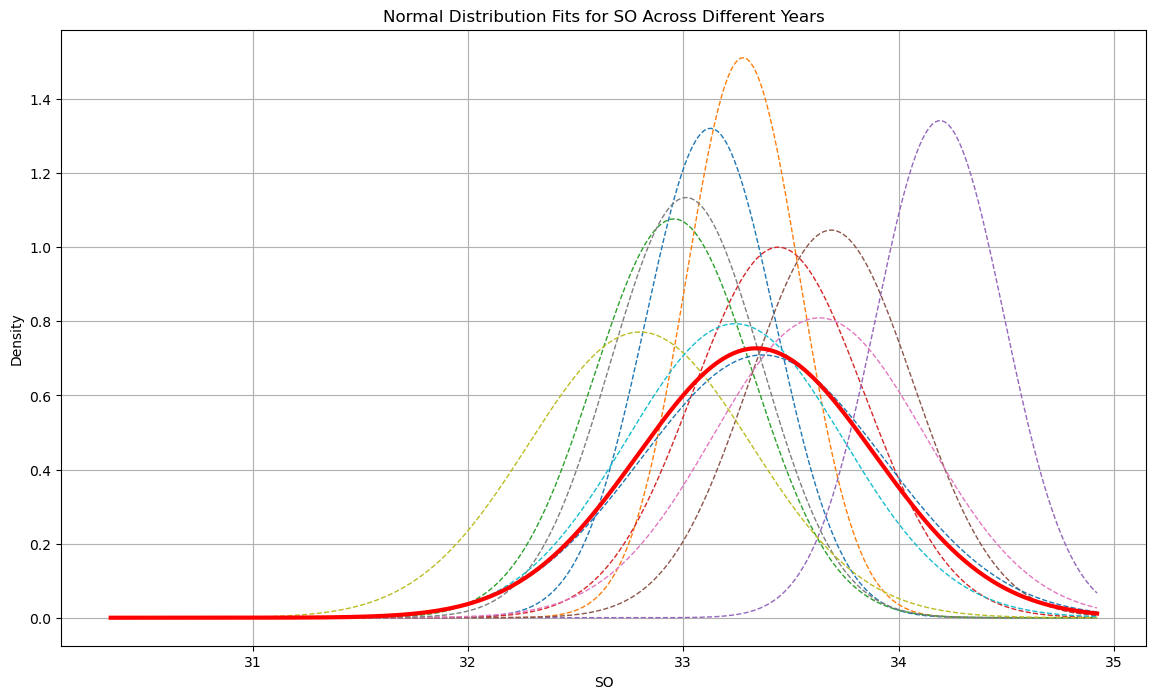

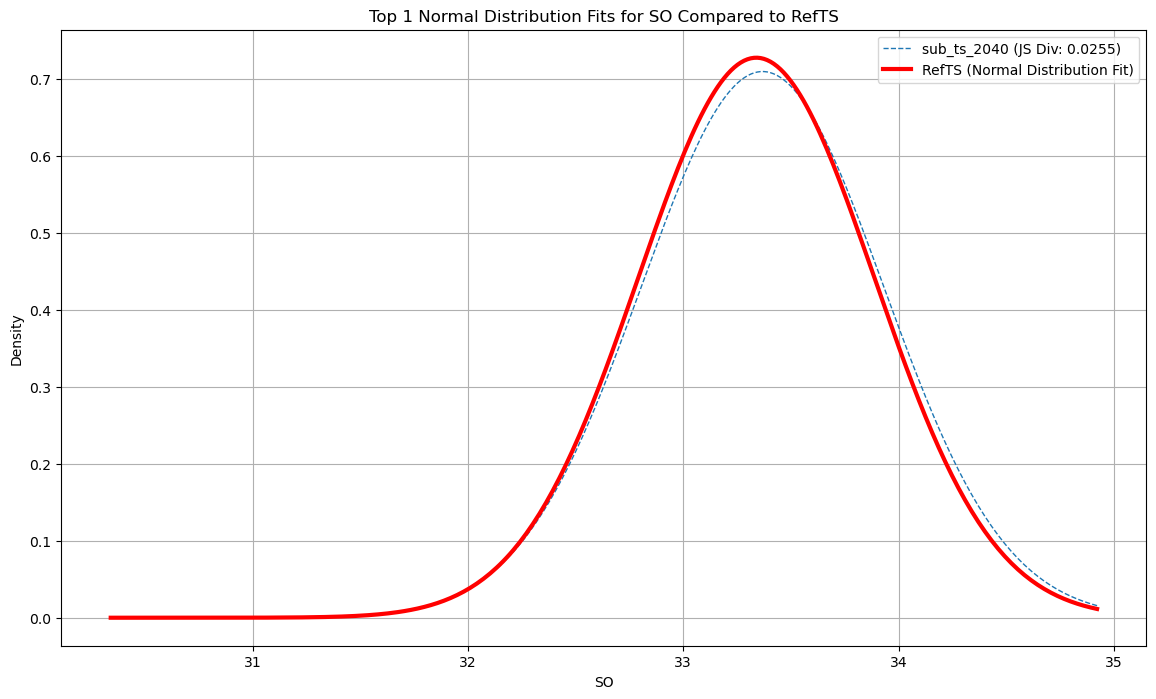

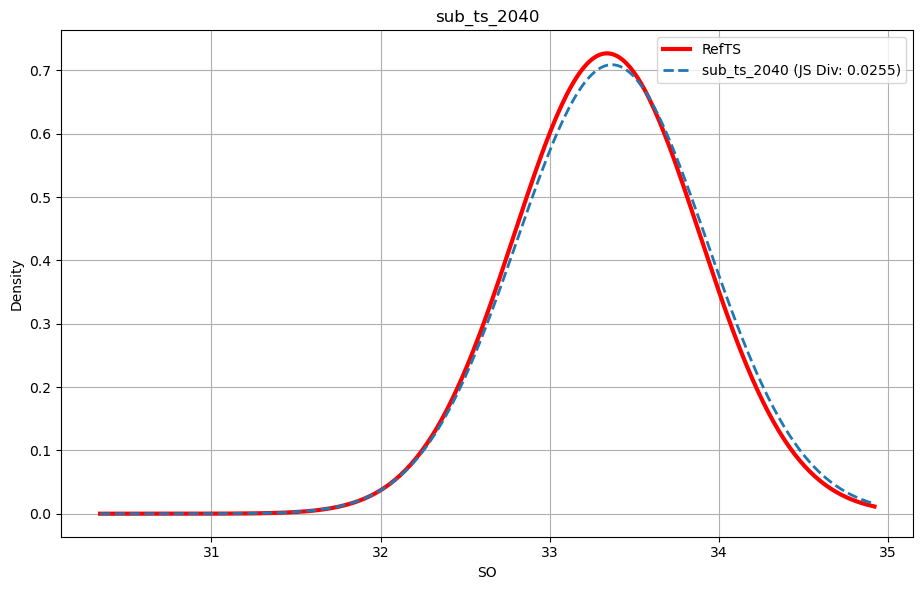

In [74]:
## Formulation of the process

# Define range for PDF calculation
min_value_variable, max_value_variable = data[variable].min(), data[variable].max()
variable_full_range = np.linspace(min_value_variable, max_value_variable, 300)

# Calculations of ref_pdf, sub_pdf
ref_pdf = calculate_pdfs(ref_ts)
js_divergence = {}  #dictionary to hold JS divergence values
subts_pdfs = {}  #dictionary to hold JSD for each subset
for key, subts in sub_ts.items():
    if not subts.empty:
        subts_pdf = calculate_pdfs(subts)
        subts_pdfs[key] = subts_pdf
        js_divergence[key] = jensenshannon(ref_pdf, subts_pdf, base=2)

## Plots
all_m1plots()
## If you want to see a specific number of best matches, put a value for n
n = 1  #If you want to see only the representative year, n=1
top_n_m1plots()  # this is for a single graph where your n number of PDFs is plotted with the RefTS
top_n_m1subplots()  #This is for individual plots



## Method 2

### Creating Synthetic Years

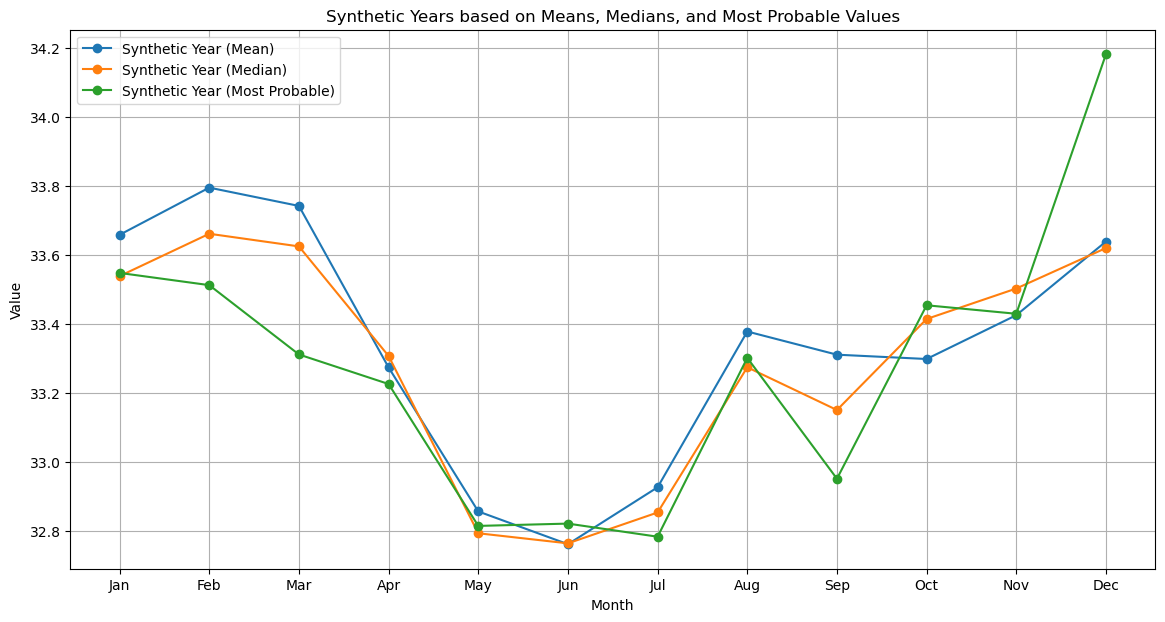

In [75]:
create_synthetic_years()

# Visualize the synthetic years
plt.figure(figsize=(14, 7))
plt.plot(months_order, synthetic_year_mean, marker='o', linestyle='-', label='Synthetic Year (Mean)')
plt.plot(months_order, synthetic_year_median, marker='o', linestyle='-', label='Synthetic Year (Median)')
plt.plot(months_order, synthetic_year_most_probable, marker='o', linestyle='-', label='Synthetic Year (Most Probable)')
plt.title('Synthetic Years based on Means, Medians, and Most Probable Values')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [76]:
# print(synthetic_year_mean)
# print(synthetic_year_median)
# print(synthetic_year_most_probable)

### Running methodology 2 for synthetic year based representative years

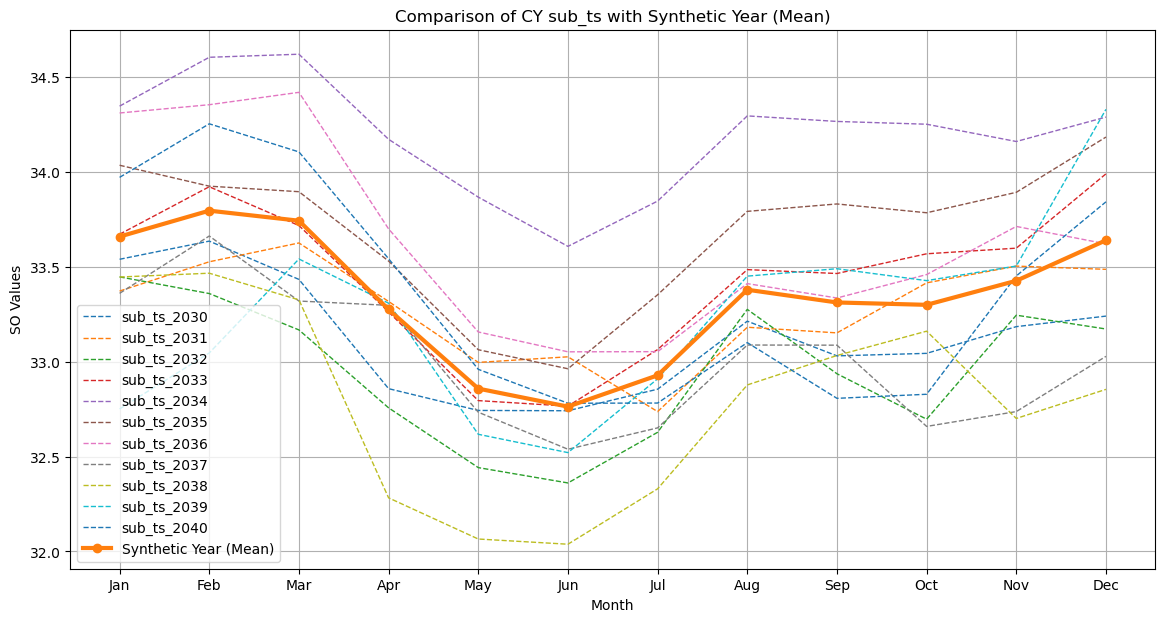

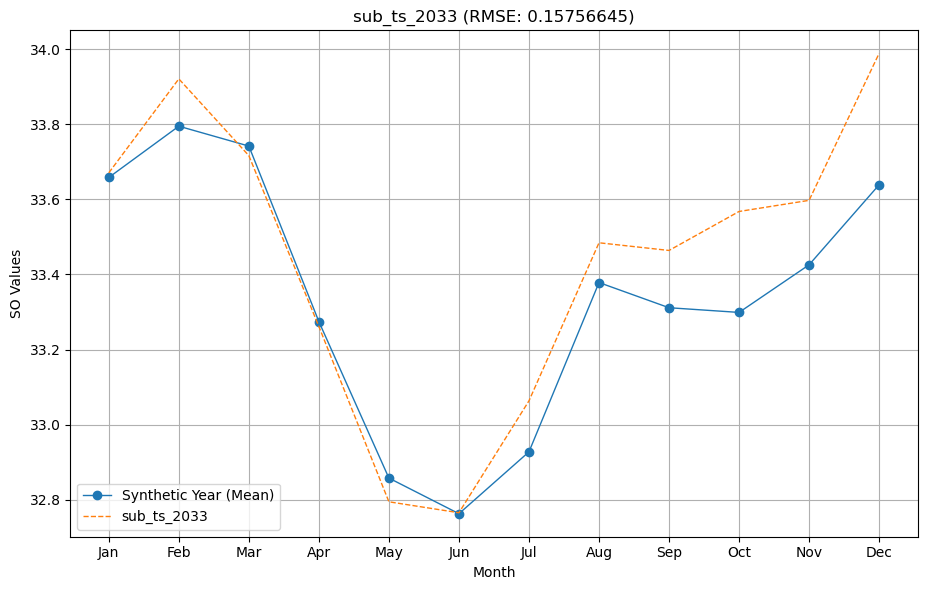

In [77]:
## Run method 2 for mean synthetic year

sy = synthetic_year_mean
sy_label = 'Synthetic Year (Mean)'
results_df_symn = run_method2()

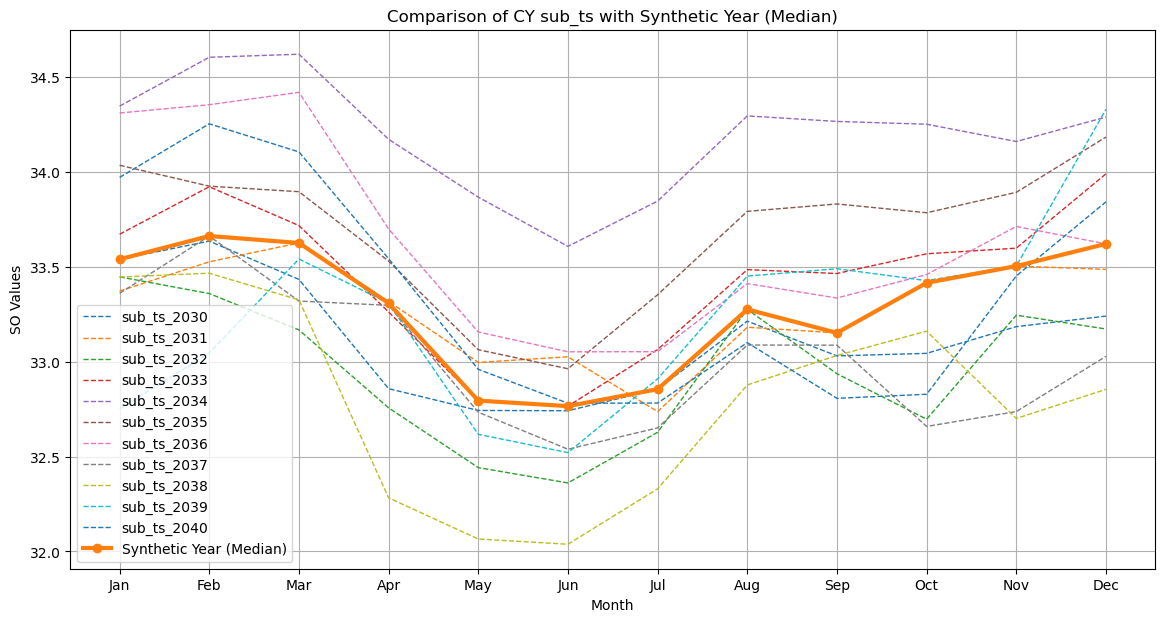

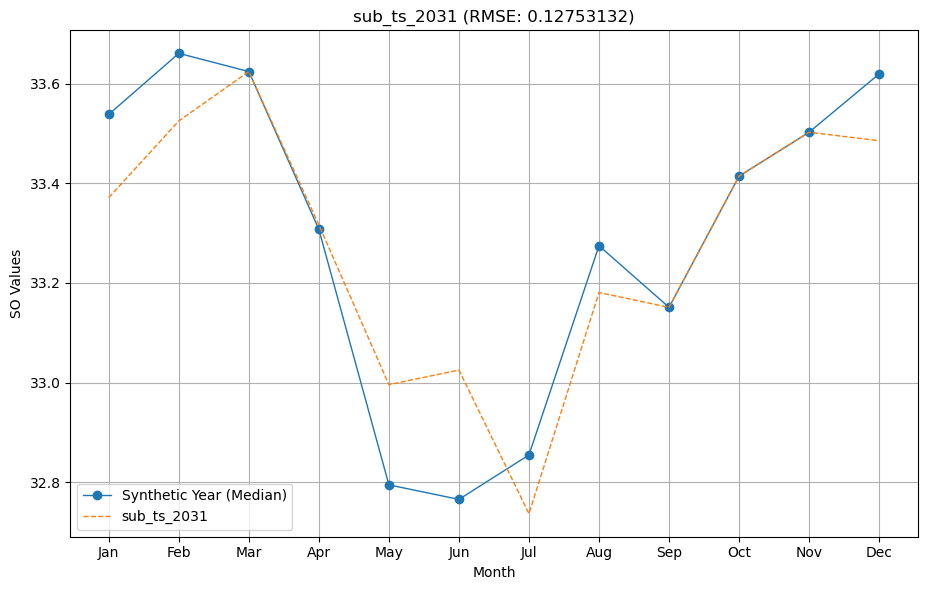

In [78]:
## Run method 2 for median synthetic year

sy = synthetic_year_median
sy_label = 'Synthetic Year (Median)'
results_df_symd = run_method2()

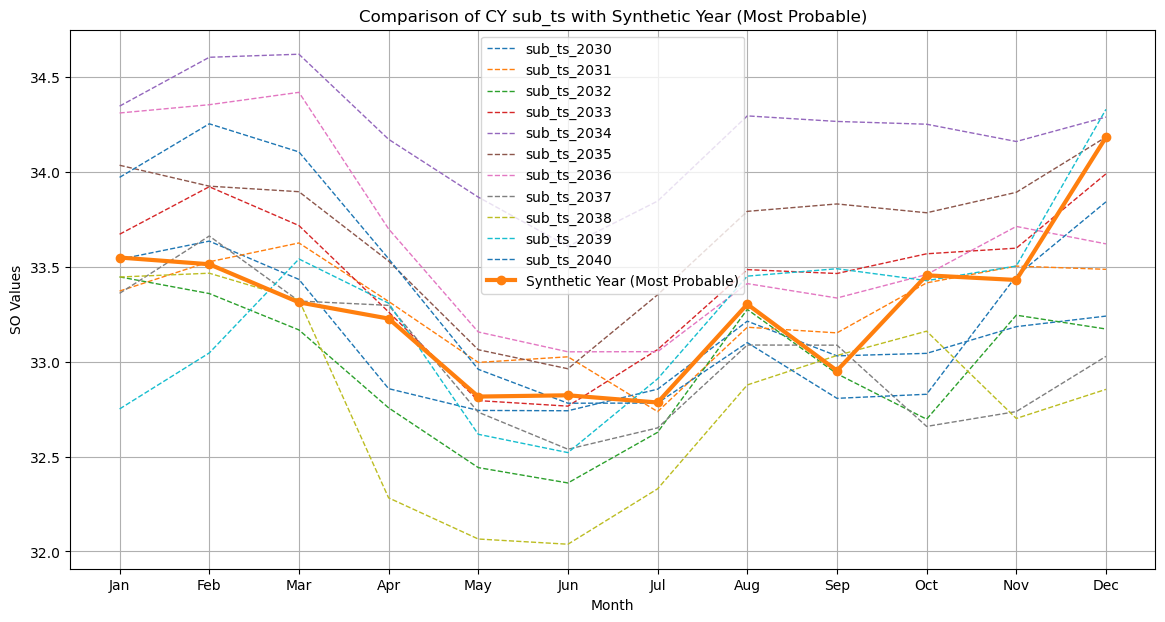

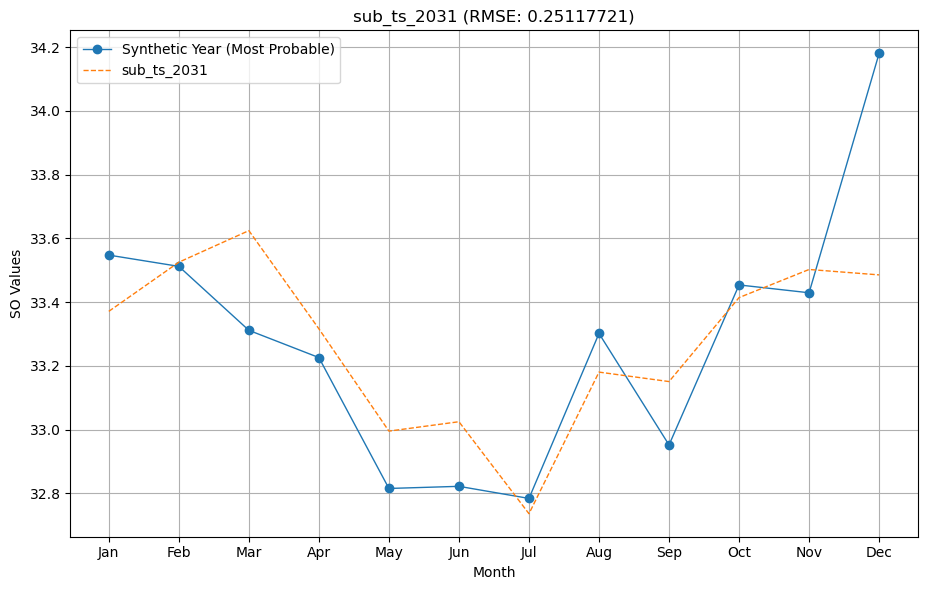

In [79]:
## Run method 2 for most probable synthetic year

sy = synthetic_year_most_probable
sy_label = 'Synthetic Year (Most Probable)'
results_df_symp = run_method2()

## Outputs

In [80]:
# Convert the js_divergence dictionary to a DataFrame
jsd_df = pd.DataFrame(js_divergence.items(), columns=['Year', 'JSD'])
symn_df = pd.DataFrame(results_df_symn)
symd_df = pd.DataFrame(results_df_symd)
symp_df = pd.DataFrame(results_df_symp)

# Sort each DataFrame by the 'Year' column alphabetically
jsd_df.sort_values(by='Year', inplace=True)
symn_df.sort_values(by='Year', inplace=True)
symd_df.sort_values(by='Year', inplace=True)
symp_df.sort_values(by='Year', inplace=True)

filename_no_csv = filename.split('.')[0]
# Define the folder name
folder_name = f'{filename_no_csv}_{mode}_{startyear}_{endyear}'
# Create the folder if it does not exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Define file paths
jsd_path = os.path.join(folder_name, f'{filename_no_csv}_{mode}_{startyear}_{endyear}_jsd.csv')
symn_path = os.path.join(folder_name, f'{filename_no_csv}_{mode}_{startyear}_{endyear}_symn.csv')
symd_path = os.path.join(folder_name, f'{filename_no_csv}_{mode}_{startyear}_{endyear}_symd.csv')
symp_path = os.path.join(folder_name, f'{filename_no_csv}_{mode}_{startyear}_{endyear}_symp.csv')

# Write DataFrames to CSV files
jsd_df.to_csv(jsd_path, index=False)
symn_df.to_csv(symn_path, index=False)
symd_df.to_csv(symd_path, index=False)
symp_df.to_csv(symp_path, index=False)


In [81]:
#Save only representative year information:
# Find the minimum metric values and corresponding years
min_jsd = jsd_df.loc[jsd_df['JSD'].idxmin()]
min_symn = symn_df.loc[symn_df['RMSE'].idxmin()]
min_symd = symd_df.loc[symd_df['RMSE'].idxmin()]
min_symp = symp_df.loc[symp_df['RMSE'].idxmin()]


representative_data = {
    'Filename': [
        jsd_path,
        symn_path,
        symd_path,
        symp_path
    ],
    'Method': [
        'jsd',
        'symn',
        'symd',
        'symp'
    ],
    'Year': [
        min_jsd['Year'],
        min_symn['Year'],
        min_symd['Year'],
        min_symp['Year']
    ],
    'Metric': [
        min_jsd['JSD'],
        min_symn['RMSE'],
        min_symd['RMSE'],
        min_symp['RMSE']
    ]
}

rep_year_df = pd.DataFrame(representative_data)
rep_year_path = os.path.join(folder_name, f'{filename_no_csv}_{mode}_{startyear}_{endyear}_representative_years.csv')
rep_year_df.to_csv(rep_year_path, index=False)